---
# Méthode OLA (Overlap-Add) pour appliquer un filtre RIF
---

## Introduction 

Dans ce notebook, on va expliquer comment économiser un grand nombre d'opérations CPU pour appliquer un filtre RIF, au prix d'un délai plus élevé entre l'entrée et la sortie du filtre, et en ayant besoin de plus de mémoire RAM. La méthode présentée ici, appelée OLA (Overlap-Add), pemet également de TRUC ET MACHIN.

Après avoir synthétisé un filtre, on a expliqué qu'on doit utiliser une convolution pour l'appliquer à un signal. Or la convolution coûte très cher en calcul (on va re-détailler ça plus loin). On va voir ici que si on peut se permettre de *bufferiser* le signal, c'est-à-dire d'enregistrer un certain (grand) nombre de valeurs du CAN en mémoire avant de les traiter, alors on peut appliquer le filtre dans le domaine de Fourier.

En effet, une convolution dans le domaine temporel est équivalente à une simple multiplication terme-à-terme dans le domaine de Fourier. Si on fait une FFT (assez économe en calcul) sur le signal d'entrée et qu'on connaît la TF du filtre, on peut alors filtrer par simple multiplication terme-à-terme.

Ajouter : QQS DETAILS + INCONVIENTS


--- 
# Filtrage causal par convolution

Pour cette première partie, un [résumé vidéo commenté "Convolution et filtres numériques" est disponible sur Youtube](https://youtu.be/VlEqIMpqFII).

On va utiliser les notations suivantes pour les signaux : 
* $x[n] \in \mathbb{R}$ est le signal d'entrée
* $h[n] \in \mathbb{R}$ est la réponse impulsionnelle du filtre
* $y[n] = (h * x)[n]$ est le signal de sortie (filtré). $y[n]  \in \mathbb{R} $

De plus :
* On note $L$ le nombre de coefficients du filtre RIF
* On note $b_l$ les coefficients du numérateur de la fonction de transfert, avec $0 \leq l \leq L-1$. Pour un filtre RIF, on rappelle que $h[l] = b_l$
* Le filtre est causal, d'où $\forall n<0, h[n] = 0$
* Le filtre est RIF, d'où $ \forall n \geq L, h[n] = 0$
* $N$ est le nombre total d'échantillons (non-nuls) en entrée

## Construction du signal d'exemple

On va générer un signal avec 3 composantes sinusoïdales ($f_1 = 1kHz, f_2=4kHz, f_3=16kHz$) et du bruit gaussien :

$$
x(t) = \cos(2 \pi f_1 t) + \cos(2 \pi f_2 t) + \cos(2 \pi f_3 t) + b(t) \\
\text{avec } b(t) \sim \mathcal{N} \left( 0, \sigma ^2 \right)
$$

Et on échantillonne ce signal à la fréquence $F_s = 50kHz$, en prenant $x[n] = x(t = n / F_s)$

On souhaitera ensuite récupérer uniquement la composante centrale $f_2$, en filtrant les composantes latérales et le bruit par un passe-bande.

Text(0, 0.5, '|X(f)|')

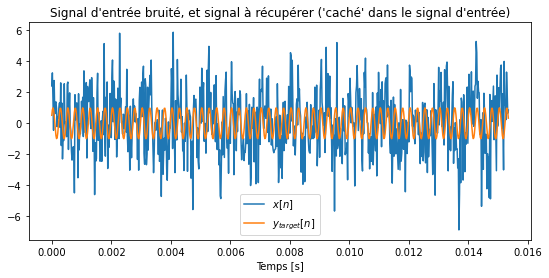

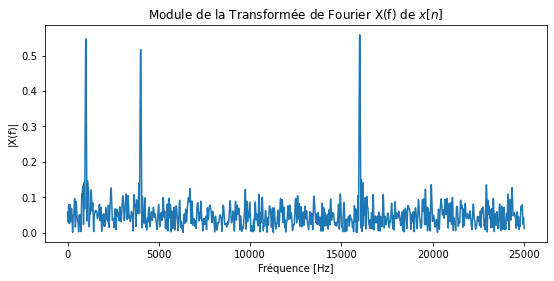

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Affichage interactif - installer extensions nécessaires
#%matplotlib widget
# OU BIEN Garder inline pour export HTML (qui intégrera aussi les vidéos)
%matplotlib inline
import scipy.signal as signal
import random
random.seed(2021)
np.random.seed(2021)  # commenter pour "lâcher" le générateur gaussien

figures_width = 9

Fs = 50e3  # échantillonnage à 50kHz
fft_block_N = 256  # Va être utilisé + tard
N = fft_block_N * 3
t = np.linspace(0.0, (N-1)/Fs, N, endpoint=True)

# Génération des signaux
f1, f2, f3 = 1e3, 4e3, 16e3  # Fréquences des raies spectrales, en Hz
nu1, nu2, nu3 = f1/Fs, f2/Fs, f3/Fs  # équivalents en fréq normalisée dans [-0.5, 0.5[
y_target = 1.0 * np.cos(2*np.pi*(f2 * t + random.random()))  # raie centrale, à récupérer
x = 1.0 * np.cos(2*np.pi*(f1 * t + random.random())) + y_target + 1.0 * np.cos(2*np.pi*(f3 * t + random.random()))
x += np.random.normal(0.0, 1.5, N)  # Bruit gaussien centré, fort écart type vs. amplitude raies spectrales
# Affichage des signaux - représentation temporelle
fig, ax = plt.subplots(1, 1, figsize=(figures_width, 4))
ax.plot(t, x)
ax.plot(t, y_target)
ax.legend([r'$x[n]$', r'$y_{target}[n]$'])
ax.set_title("Signal d'entrée bruité, et signal à récupérer ('caché' dans le signal d'entrée)")
ax.set_xlabel('Temps [s]')
# FFT avec zero-padding pour voir le spectre en détail
fig, ax = plt.subplots(1, 1, figsize=(figures_width, 4))
M = 2**14  # taille FFT avec zero-padding auto dans numpy.fft
X = np.abs(np.fft.fft(x, M))[0:M//2] / N  # Amplitude normalisée, 1/2 spectre pour les fréquences positives
ax.plot(np.linspace(0.0, 0.5, M//2) * Fs, X)
ax.set_title(r'Module de la Transformée de Fourier X(f) de $x[n]$')
ax.set_xlabel('Fréquence [Hz]')
ax.set_ylabel(r'|X(f)|')

## Synthèse du filtre RIF et filtrage par convolution

On va ici synthétiser un filtre RIF par méthode "de fenêtrage", sans rappeler en quoi cette méthode consiste.
Le filtre obtenu est décrit par sa réponse impusionnelle discrète $h[l]$ avec $0 \leq l \leq L-1$.

La taille $L$ de la réponse impulsionnelle est aussi le nombre de coefficients du filtre. Ici, on a choisi un filtre de taille $L=51$.

Text(0.5, 0, 'Fréquence [Hz]')

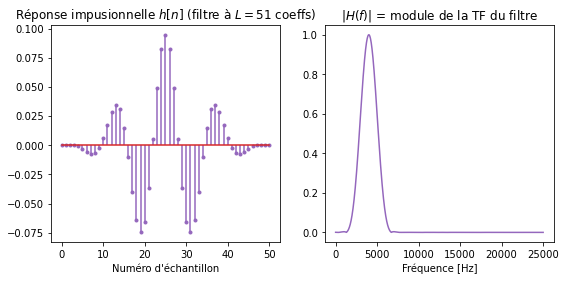

In [3]:
# Exemple de convolution avec filtre passe-bande synthétisé par méthode basique : R.I. fenêtrée
L = 51  # Filtre à 51 coefficients
h = signal.firwin(L, [0.12, 0.20], pass_zero='bandpass')  # Attention : fréq normalisée dans [-1, 1[
fig, axes = plt.subplots(1, 2, figsize=(figures_width, 4))
axes[0].stem(h, linefmt='C4-', markerfmt='C4.')
axes[0].set_title('Réponse impusionnelle $h[n]$ (filtre à $L=51$ coeffs)')
axes[0].set_xlabel("Numéro d'échantillon")
axes[1].plot(np.linspace(0.0, 0.5, M//2, endpoint=False) * Fs, np.abs(np.fft.fft(h, M))[0:M//2], 'C4-')
axes[1].set_title('$|H(f)|$ = module de la TF du filtre')
axes[1].set_xlabel('Fréquence [Hz]')

On peut maintenant appliquer notre filtre $h[n]$ à notre signal d'entrée $x[n]$. Pour cela, la méthode de base est la convolution discrète des signaux $x[n]$ et $h[n]$. On peut considérer que le filtre, via sa réponse impulsionnelle $h[n]$, est lui-même un signal !

Pour obtenir la sortie $y[n]$, on utilise la convolution qui est définie par :

$$
y[n] = (h*x)[n] = \sum_{k=-\infty}^{+\infty} h[k] x[n-k]
$$

Mais avec un filtre RIF, on sait que $h[k] = 0$ si $k<0$ ou bien si $k>L-1$. On peut donc (heureusement) simplifier cette somme infinie, et on obtient :

$$
y[n] = (h*x)[n] = \sum_{k=0}^{L-1} h[k] x[n-k]
$$

On voit que :
* pour calculer la sortie $y[n]$ à un instant donné $n \in \mathbb{Z}$, il faut connaître les $L$ derniers échantillons de l'entrée $x$, c'est à dire : $x[n], x[n-1], ..., x[n-(L-1)]$
* Dans la somme, on ne parcourt pas les signaux $h$ et $x$ dans le même sens. On va en "retourner" un par rapport à l'autre, avant de les multiplier.

In [5]:
from matplotlib import animation, rc
from IPython.display import HTML

N_ = 3*L + L-1  # Convolution animée : sur le début du signal seulement
signal_amplitudes_display = [-4.1, 4.1]
# On allonge le signal d'entrée sur les n<0, pour commencer la conv à n=0
x_ = np.hstack((np.zeros(L-1), x[0:N_ - (L-1)]))
abscisses_echantillons = np.arange(-(L-1), N_ - (L-1))
y_target_ = y_target[0:N_ - L]
# On pré-calcule y (rendu HTML demande des incides aléatoires...)
y_conv = signal.convolve(x_, h, mode='same', method='direct')
# Affichage animé - rendu vidéo
fig, axes = plt.subplots(4, 1, figsize=(figures_width, 7.5), sharex=True)
axes[0].set_title("Signal d'entrée $x[n]$ et signal $y_{target}[n]$ qu'on souhaite récupérer")
axes[0].stem(abscisses_echantillons, x_, markerfmt='.')
axes[0].stem(y_target_, linefmt='C1-', markerfmt='C1.')
axes[0].legend(['$x[n]$', '$y_{target}[n]$'])
axes[0].set_ylim(signal_amplitudes_display)
def animate(n):
    axes[1].clear()
    axes[1].set_title("Portion du signal $x[n]$ qui sert pour la convolution avec $h$")
    axes[1].set_ylim(signal_amplitudes_display)
    current_x = x_[n: n+L]
    axes[1].stem(np.arange(n-(L-1), n+1), current_x, markerfmt='C0.')
    axes[1].text(n+2, -0.3, "$x[n]$")
    axes[1].text(n-(L-1)-24, -0.3, "$x[n-L+1]$")
    axes[2].clear()
    axes[2].stem(np.arange(n-(L-1), n+1), h[::-1], linefmt='C4-', markerfmt='C4.')  # h symétrique, on pourrait enlever le retournement horizontal
    axes[2].set_title("Réponse impulsionnelle $h$ décalée et retournée horizontalement")
    axes[2].legend(['$h$'])
    axes[2].text(n+2, -0.005, "$h[0]$")
    axes[2].text(n-(L-1)-18, -0.005, "$h[L-1]$")
    axes[3].clear() 
    axes[3].set_title("Sortie $y_{conv}[n]$ = résultat de la convolution $(h*x)[n]$")
    axes[3].set_xlabel("Numéro d'échantillon")
    axes[3].set_ylim(signal_amplitudes_display)
    axes[3].stem(np.arange(0, n+1), y_conv[0:n+1], linefmt='C1-', markerfmt='C1.')
    axes[3].text(-50.0, -0.7, "n={}".format(n), fontsize=20)
    axes[3].text(n+2, -0.3, "$y[n]$")
    fig.tight_layout()
    return ()
#for k in range(20):
#    animate(k)
# Frames pour les k>=0 (on convolue seulement pour les 'vrais' échantillons x[k])
anim = animation.FuncAnimation(fig, animate, frames=N_-L, interval=200, blit=True)  # N_-L frames
plt.close()  # on ne garde que l'anim

**Rappel** : pour calculer la sortie $y[n]$ à un instant $n$ donné, on fait le calcul :

$$
y[n] = (h*x)[n] = \sum_{k=0}^{L-1} h[k] x[n-k] \\
= h[0]x[n] + h[1]x[n-1] + ... + h[L-2] x[n-(L-2)] + h[L-1] x[n-(L-1)]
$$

In [6]:
HTML(anim.to_html5_video())

## Quelques remarques

### Filtre

* Ici, en particulier, la réponse impulsionnelle $h[n]$ est symétrique par rapport à son échantillon milieu. Donc "retourner h" horizontalement ne change rien !
    * Attention cependant : tous les filtres numériques n'ont pas une telle symétrie.
* On peut améliorer le filtre
* La convolution n'est pas la seule manière de faire un filtrage
    * Mais c'est la plus "temps-réel" ! Dès qu'on a un nouveau $x[n]$, on peut calculer $y[n]$ (pas besoin d'attendre)
    
### Quantité de calcul pour appliquer la convolution

Avec la convolution, on rappelle que pour chaque échantillon $N$, il faut calculer une somme de $L$ termes, c'est-à-dire $L-1$ additions, chacun des $L$ termes étant issus d'une multiplication. La quantité d'opérations à effectuer pour obtenir les $y[n]_{0 \leq n < N}$ échantillons à calculer est donc :

$$
\mathcal{C}_{conv} = NL(L-1)
$$

L'unité de cette quantité est le FLOP = Floating-Point OPeration. On pourrait aussi donner la puissance de calcul nécessaire en FLOPS = FLOP/seconde, qu'on peut noter par exemple $\mathcal{P}$. On a alors théoriquement besoin d'une puissance de calcul de :

$$
\mathcal{P}_{conv} = F_s (L + (L-1)) \approx 2 F_s L
$$

Par exemple pour un signal audio à $48kHz$ avec $L=51$ (ce qui est un "petit" filtre), on doit avoir une puissance de calcul $P_{conv} \approx 4,9$ MFlops. La fréquence théorique d'un CPU pour exécuter ce filtrage est de 4,9 MHz, mais il faut prendre une (très) grande marge en prévision de tous les calculs annexes : déplacement de données, appels de fonctions, ... On peut appeler ça l'*overhead* de l'opération de filtrage elle-même.

On suppose qu'on fait ici du traitement du signal sur float, ce qui n'est pas toujours le cas. Pour réduire les coûts au maximum, on pourrait écrire la convolution avec uniquement des opérations sur nombres entiers à virgule fixe. C'est plus compliqué, mais on peut alors utiliser des microcontrôleurs sans FPU (Floating-Point Unit), qui coûtent beaucoup moins cher et consomment en général moins d'énergie.

On va rester dans l'hypothèse d'une représentation float des signaux. Avec la plupart des CPUs modernes (y compris les petits ARM avec VFP, SIMD, NEON), on a l'instruction MAC : Multiply and Accumulate (ou instruction similaire) sur floats. Sur les DSPs, on a bien sûr également ce genre d'instruction - mais le terme DSP tend à disparaître car les CPUs et microcontrôleurs sont en 2021 quasi-tous des DSPs. En utilisant des MAC, la puissance de calcul minimale pour la convolution devient :

$$
\mathcal{P}_{conv} = F_s L
$$

Pour $N$ échantillons, la quantité d'opérations correspondante est :

$$
\mathcal{C}_{conv} = NL
$$

On peut encore réduire la puissance de calcul en diminuant la précision des floats : c'est le principe des instructions SIMD (Single Instruction, Multiple Data) disponible sur de nombreux processeurs, plus rarement sur des microcontrôleurs (c'est quand même à explorer, les architectures évoluent plus vite que ce qu'on peut imaginer). Par exemple : sur ARM 32 bits avec SIMD, si on fait du DSP sur floats 16 bits (qui ne sont pas les float standard IEEE), on peut espérer pouvoir faire un double MAC en 1 instruction ASM, et donc encore réduire la puissance de calcul allouée au filtrage par convolution.

---

# Filtrage directement dans le domaine de Fourier

## Transformation du produit de convolution en produit terme-à-terme

On utilisera ici indifféremment acronymes FFT et TFD (Transformier de Fourier Discrète), car en pratique on fait toujours la TFD par l'algorithme FFT, sur des signaux de longueur $N = 2^a$ (quitte à faire du zero-padding pour compléter le signal). On note cette FFT :

$$
X[k] = FFT(x)[k], \forall k \in [0, N-1]
$$

En particulier, on connaît une propriété très intéressante de toutes les TF et TF<sup>-1</sup>, y compris la TFD : les produits de convolution sont transformés en produit terme-à-terme. Pour nos suites $x$ et $h$, on a donc $\forall k \in [0, N-1]$ :

$$
FFT(h*x)[k] = H[k] . X[k]
$$

Puisque la FFT est inversible (on note IFFT son inverse), on pourrait intuitivement appliquer un filtre de la manière suivante :

$$
y[n] = (h*x)[n] \\
= IFFT \left( FFT(h*x) \right)[n] \\
= IFFT( H.X )[n]
$$

En pratique, ce calcul correspond aux sous-étapes suivantes :
* On calcule $X$ et $H$ par FFT
* On obtient $Y[k] = FFT(y)[k]$ en faisant une multiplication terme-à-terme : $\forall k \in [0, N-1], Y[k] = H[k].X[k]$
* On obtient notre signal de sortie $y[n]$ par IFFT sur $Y$

## Exemple en pratique



In [26]:
def display_fft_filtering(N_red):
    """ N_red : nombre d'éch de x à filtrer
        y_ref : sortie y obtenue par convolution """
    x_red = x[0:N_red]
    t_red = t[0:N_red]
    fig, axes = plt.subplots(4, 1, figsize=(figures_width, 7.5))
    axes[0].plot(t_red, x_red)
    axes[0].set_title("$N_{red} = $" + "{} premiers échantillons de ".format(N_red) + "$x[n]$")
    axes[0].legend(['$x[n]$'])
    axes[0].set_xlabel('Temps [s]')
    X = np.fft.fft(x_red)  # FFT complexe, on doit garder la phase !
    H = np.fft.fft(h, N_red)  # w/ zero-padding
    axes[1].plot(np.linspace(0.0, 0.5, N_red//2, endpoint=False) * Fs, np.abs(X)[0:N_red//2] / N_red, 'C0-')
    axes[1].plot(np.linspace(0.0, 0.5, N_red//2, endpoint=False) * Fs, np.abs(H)[0:N_red//2], 'C4-')
    axes[1].legend(['$X = FFT(x), normalisée$', '$H = FFT(h)$ sur $N_{red}=$' + '{} éch.'.format(N_red)])
    axes[1].set_xlabel('Fréquence [Hz]')
    axes[1].set_ylabel('Module de la FFT')
    axes[1].set_ylim([-0.1, 1.1])
    axes[2].set_ylim([-0.1, 1.1])
    Y = X*H
    axes[2].plot(np.linspace(0.0, 0.5, N_red//2, endpoint=False) * Fs, np.abs(Y)[0:N_red//2] / N_red, 'C1-')
    axes[2].legend(['$Y = FFT(y) = X.H$, normalisée'])
    y_fft = np.real(np.fft.ifft(Y))  # real nécessaire à cause des arrondis sur nbs complexes
    axes[3].plot(t_red, y_fft, 'C1-')
    axes[3].legend(['$y_{fft} = IFFT(Y)$'])
    fig.tight_layout()
    return y_fft

N_reduced = 128
y_fft = display_fft_filtering(N_reduced)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Remarques pour les plots ci-dessus
* On affiche les données sous forme de plot classique (en ligne), mais il faut bien garder en tête qu'il s'agit d'échantillons discrets, et non pas de signaux et de TF continus
* La partie de la FFT en fréquences négatives est conservée (et utilisée) mais pas affichée

### Allure des signaux : comparaison avec le filtrage par convolution

On constate que ce filtrage fait bien ressortir notre composante recherchée à 4 kHz. Pour mieux comprendre ce qu'il s'est passé, on va comparer ce signal $y_{fft}$ obtenu via le domaine de Fourier, avec le signal $y_{conv}$ obtenu par convolution, et avec le signal $y_{target}$ qui est *vraiment* contenu dans $x$. C'est ce $y_{target}$ qu'on essaie de retrouver.

In [7]:
t_red = t[0:N_red]
# On re-calcule un y_conv avec une taille adaptée à ce qu'on a fait en FFT
fig, axes = plt.subplots(2, 1, figsize=(figures_width, 4))
axes[0].plot(t_red, y_fft, 'C1-')
axes[0].plot(t_red, y_conv[0:N_red], 'C5-')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'y_fft' is not defined

## Quantité de calcul 

L'intérêt de la méthode de filtrage proposée ci-dessus est la quantité de calcul, lorsque le filtre contient un grand nombre de coefficients.

# Méthode Overlap-Add : filtrage "temps-réel" dans le domaine de Fourier

## Séparation du signal à filtrer

## Inconvénients de la méthode OLA

## Remise en perspective : synthèse de filtres

on partait des gabarits en fréquence... peut-on alors appliquer un filtre idéal en TF, avec la méthode OLA ?
parler du lien qu'on doit garder entre coeffs du RIF et application en TF direct